In [ ]:
#|default_exp fisher

By Fred Guth

One-sentence summary: Create a callback that calculates the Fisher Information in the weights and uses it to speedup learning.

## Motivation

During training, a model stores information about the training dataset in its weights, $I[D;W]$.  Ideally, it would only store information that is useful for the task, but most of what is stored in the weights is information about the input and does not relate to the task.

Knowing how much information our model retains during training can can be useful for:
* checking if the model is overfitting;
* updating the learning rate
* creating a regularization term for the loss

To calculate the Shannon information in the weights, we would need to know the true $\Theta$ that we are estimating with our $W$. Still, we can calculate the Fisher Information in the weights, which is a lower bound for the Shannon Information.


## A Simple Baseline

In [1]:
#|export
from __future__ import annotations
import random,math,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from torch import tensor,nn,optim
import torch.nn.functional as F
from torch.distributions import Categorical
import torchvision.transforms.functional as TF
from datasets import load_dataset
import time
from miniai.datasets import *
from miniai.learner import *
from torcheval.metrics import MulticlassAccuracy,Mean
from tqdm.auto import tqdm

/home/fredguth/.miniconda3/envs/py39/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
from IPython.core.debugger import set_trace
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

In [3]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024*8

@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=6)

  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
inplace?

Signature: inplace(f)
Docstring: <no docstring>
File:      ~/code/course22p2/miniai/datasets.py
Type:      function


In [ ]:
def get_model(): 
    m,nh = 28*28,50
    return nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

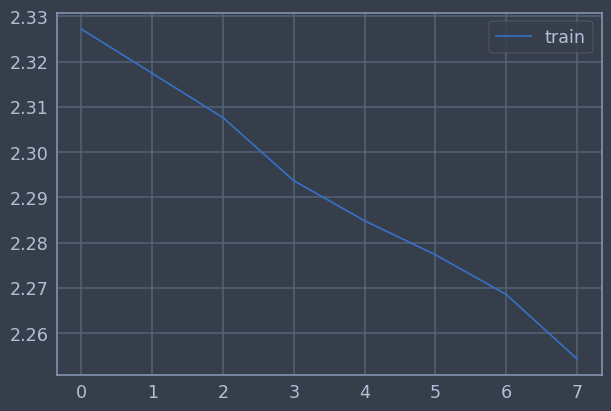

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.02, cbs=cbs)
learn.fit(1)

## Fisher  Information

Let $P_{\theta}$ denote a family of parametric distributions on a space $\mathcal{X}$ with probability mass or density function given by $p_{\theta}$.

The **Fisher information matrix** $F \in \mathbb{R}^{N \times N}$ of a DNN with learnable parameter $\theta \in \mathbb{R}^{N}$ is the matrix:
	\begin{align}
		[F(\theta)]_{ij} &:= \mathbb{E}_{x} \left[ \nabla_{\theta_i} \log p_{\theta}(X) \cdot  \nabla_{\theta_j} \log p_{\theta}(X)^\top \right] \\
		&= \mathbb{E}_{\theta}\left[ \frac{\partial \ell}{\partial \theta_i} \cdot \frac{\partial \ell}{\partial \theta_j}^\top \right],
	\end{align}
	where $\ell(x|\theta)= \log p(x|\theta)$ is often called the score function.

The Fisher information measures the overall sensitivity of the functional relationship $p$ to changes of $\theta$ by weighting the sensitivity at each potential outcome $x$ w.r.t $p_{\theta}(x)$ @{maarten:2017}

A common simplification of the **Fisher Information Matrix (FIM)** is to reduce it to the diagonal:
\begin{align}
	[I_{X}(\theta)]_{i} &:= \mathbb{E}_{\theta} \left[ \nabla_{\theta_i} \log p_{\theta}(X)^2 \right]
\end{align}

### Cross Entropy Loss

Cross-entropy is the average number of bits needed to encode data coming from a source X with distribution p(x) when using model q(x).
    \begin{align}
     H_{p,q}[X]&=−\sum{p(x)\log q(x)}, x \in A(X) \\
     H_{p,q}[X]&=-\mathbb{E}_{x}\log q(x), x \in A(X)
    \end{align}


## Fisher  Information Callback

Let's create a Callback to calculate the fisher information in the weights of our model.


In [ ]:
#|export
from nngeometry.metrics import FIM, FIM_MonteCarlo
from nngeometry.object import PMatKFAC, PMatDiag, PVector
import time

In [ ]:
tic = time.time()
F_kfac = FIM(model=learn.model,
                 loader=learn.dls.valid,
                 representation=PMatKFAC,
                 n_output=10,
                 variant='classif_logits',
                 device='cuda')
tac = time.time()
tac-tic

3.743682622909546

In [ ]:
tic = time.time()
F_mc = FIM_MonteCarlo(model=learn.model,
                 loader=learn.dls.valid,
                 representation=PMatDiag,
                 variant='classif_logits',
                 device='cuda')
tac = time.time()
tac-tic

3.3968558311462402

In [ ]:
tic = time.time()
F_mc_k = FIM_MonteCarlo(model=learn.model,
                 loader=learn.dls.valid,
                 representation=PMatKFAC,
                 variant='classif_logits',
                 device='cuda')
tac = time.time()
tac-tic

3.403806209564209

In [ ]:
F_kfac.trace(), F_mc.trace(), F_mc_k.trace()

(tensor(26.88, device='cuda:0'),
 tensor(27.15, device='cuda:0'),
 tensor(26.87, device='cuda:0'))

In [ ]:
F_kfac.get_diag().shape

torch.Size([39760])

In [ ]:
param_sizes = {n:p.numel() for n,p in learn.model.named_parameters() if p.requires_grad}
param_sizes['total']=sum(param_sizes.values())
param_sizes

{'0.weight': 39200,
 '0.bias': 50,
 '2.weight': 500,
 '2.bias': 10,
 'total': 39760}

In [ ]:
#|export
class FisherCB(Callback):
    def __init__(self, representation = PMatKFAC): 
        fc.store_attr()
        self.Fs = []
    def _log(self, d): print({**d, **self.learn.epoch, **self.learn.training})
    def before_fit(self): self.learn.fisher = self
    def after_epoch(self):
        if not self.learn.model.training: raise CancelEpochException()
        else:
            F = FIM(model=learn.model,
                 loader=learn.dls.valid,
                 representation=self.representation,
                 n_output=10,
                 variant='classif_logits',
                 device='cuda')
            self.Fs.append(F)

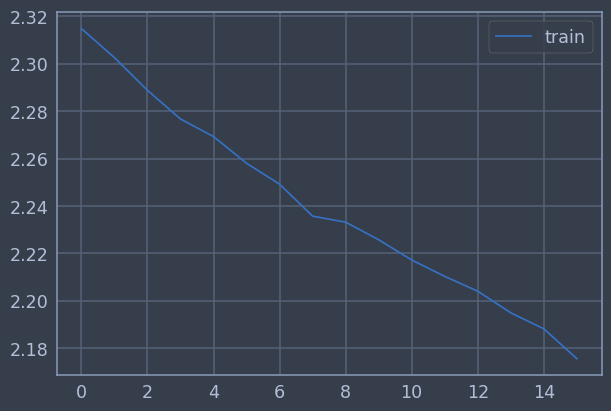

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
fcb = FisherCB()
cbs = [TrainCB(), DeviceCB(),fcb, metrics, ProgressCB(plot=True)]
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.02, cbs=cbs)
learn.fit(2)

In [ ]:
fcb.Fs[0].trace(), fcb.Fs[1].trace()

(tensor(27.04, device='cuda:0'), tensor(28.93, device='cuda:0'))

## Fisher Infor Metric
Let's create a metric to check the amount of information during training

In [ ]:
class Metric:
    def __init__(self): self.reset()
    def reset(self): self.vals,self.ns = [],[]
    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)
    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals)*ns).sum()/ns.sum()
    def calc(self, inps, targs): return inps

In [ ]:
class FisherInfo(Metric):
    def __init__(self, fcb: FisherCB): fc.store_attr()
    def update(self, inputs, targs):
            self.result = self.fcb.Fs[-1].trace() if (len(self.fcb.Fs) > 0) else 0
    def compute(self):
        return self.result
    @property
    def value(self):
        return self.result
    @property
    def name(self): return 'fisher'

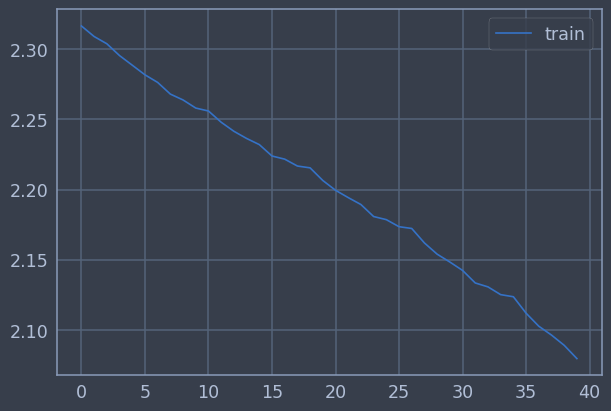

In [ ]:
fcb = FisherCB()
metrics = MetricsCB(accuracy=MulticlassAccuracy(), fisher=FisherInfo(fcb))
metrics.order = fcb.order+1
cbs = [TrainCB(), DeviceCB(), fcb, metrics, ProgressCB(plot=True)]
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.02, cbs=cbs)
learn.fit(5)

## Natural Gradient
The Fisher Information is the negative of the Hessian of the Loss w.r.t to the parameters.
We can use the hessian to approximate the loss function to a polynomial in the neighborhood of the minimum value of $\theta$. This leads to a update function where the learning rate is the inverse of the FIM.

In [ ]:
class FisherCB(Callback):
    def __init__(self, representation = PMatKFAC, natural_gradient = False): 
        fc.store_attr()
        self.Fs = []
    def _log(self, d): print({**d, **self.learn.epoch, **self.learn.training})
    def before_fit(self): self.learn.fisher = self
    def after_epoch(self):
        if not self.learn.model.training: raise CancelEpochException()
        else:
            F = FIM(model=learn.model,
                 loader=learn.dls.valid,
                 representation=self.representation,
                 n_output=10,
                 variant='classif_logits',
                 device='cuda')
            if self.natural_gradient: self.learn.lr = 1/F.trace()
            self.Fs.append(F)

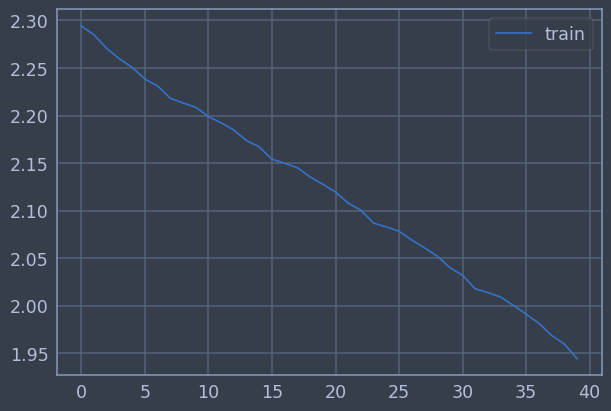

In [ ]:
fcb = FisherCB(natural_gradient=True)
metrics = MetricsCB(accuracy=MulticlassAccuracy(), fisher=FisherInfo(fcb))
metrics.order = fcb.order+1
cbs = [TrainCB(), DeviceCB(), fcb, metrics, ProgressCB(plot=True)]
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.02, cbs=cbs)
learn.fit(5)

In [ ]:
# class FisherCB(Callback):
#     def __init__(self, representation = PMatKFAC, natural_gradient = False, beta = None): 
#         fc.store_attr()
#         self.Fs = []
#     def _log(self, d): print({**d, **self.learn.epoch, **self.learn.training})
#     def before_fit(self): self.learn.fisher = self
#     def after_epoch(self):
#         if not self.learn.model.training: raise CancelEpochException()
#         else:
#             F = FIM(model=learn.model,
#                  loader=learn.dls.valid,
#                  representation=self.representation,
#                  n_output=10,
#                  variant='classif_logits',
#                  device='cuda')
#             if self.natural_gradient: self.learn.lr = 1/F.trace()
#             if self.beta is not None:
#                 self.learn.loss_func = lambda *args, **kwargs: self.learn.loss_func(args, kwargs) 
# #                 + self.beta * F.trace()
#             self.Fs.append(F)

In [ ]:
# fcb = FisherCB(natural_gradient=False, beta=0.5)
# metrics = MetricsCB(accuracy=MulticlassAccuracy(), fisher=FisherInfo(fcb))
# metrics.order = fcb.order+1
# cbs = [TrainCB(), DeviceCB(), fcb, metrics, ProgressCB(plot=True)]
# learn = Learner(get_model(), dls, F.cross_entropy, lr=0.02, cbs=cbs)
# learn.fit(2)